In [1]:
import pandas as pd
import numpy as np
import os #hi
os.chdir(r"D:\ML project")

In [2]:
df1=pd.read_excel('df1.xlsx')#importing dataframes to persist the previous train and test split 
df2=pd.read_excel('df2.xlsx')

In [6]:
#df_train_train.to_csv('tain.csv')
#df_train_valid.to_csv('txt.csv')

# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CHANNEL = 3
N_CLASSES = df1['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Model Building

Steps in model creation:<br>
1.Load data<br>
2.Define model<br>
3.Model compilation<br>
4.Model training<br>
5.Making Predictions<br>
6.Model Evaluation<br>

# 1. Load Data(given data+augmented data)

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator#The ImageDataGenerator class allows your model to receive
                                                        #new variations of the images at each epoch.(Data Augmentation)
                                                #(only returns transformed images,but not adds to existing set of images)
HEIGHT = 320
WIDTH = 320
BATCH_SIZE = 8
N_CLASSES = df1['diagnosis'].nunique()
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
             #rescale- used to rescale pixel values from the range of 0-255 to the range 0-1 preferred for neural network models.(normalization), by setting the rescale argument to a ratio by which each pixel can be multiplied to achieve the desired range.
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=train,  # loads the image dataset in memory and generates batches of augmented data
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,#produce BATCH_SIZE no.of images in each iteration of the training.
                                                      class_mode="categorical",#since,more than 2 classes to predict,else binary
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training',#validate_filenames=False
                                                     ) # set as training data
    #no valid dataset,so create one
    valid_generator=train_datagen.flow_from_dataframe(dataframe=train,   #loads the image dataset in memory and generates batches of augmented data
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,#produce BATCH_SIZE no.of images in each iteration of the training.
                                                      class_mode="categorical",#since,more than 2 classes to predict,else binary    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation',
                                                     )# set as validation data
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=test,  # loads the image dataset in memory and generates batches of augmented data
                                                      directory = "./valid_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None,
                                                     )
    
    return train_generator,valid_generator,test_generator
#Remember to import excel/csv data that is preserved from the previous file,because they are used in extracting resized and preprocessed images

In [4]:
df1['diagnosis'] = df1['diagnosis'].astype(str)#to avoid error
df1['diagnosis'] = df1['diagnosis'].astype(str)
df2['diagnosis'] = df2['diagnosis'].astype(str)

In [6]:
train_generator,valid_generator,test_generator = img_generator(df1,df2)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


# 2.Defining the Model

In [7]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D,Conv2D,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)#Input() is used to represent a Keras tensor
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)#transfer learning-Resnet50
    #ImageNet is an image database organized according to the WordNet hierarchy,designed for use in visual object recognition software research. 
    #More than 14 million images have been hand-annotated by the project to indicate what objects are pictured
    
    
    #Setting include_top to False means it will allow adding input and output layers custom to a problem
    #ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer)
    
    #base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    #https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
    #h5-An H5 is one of the Hierarchical Data Formats (HDF) used to store large amount of data  in the form of multidimensional arrays
    #The format is primarily used to store scientific data that is well-organized for quick retrieval and analysis.
    
    x=Conv2D(64,kernel_size=3,activation='relu')(base_model.output)#64-number of filters of size 3*3
    x=MaxPooling2D(pool_size=(2,2))(x)
    
    #add a fully connected output layer to the model where the learning can happen:
    x = GlobalAveragePooling2D()(base_model.output)
    
    x = Dropout(0.5)(x)#Dropout layers have been the go-to method to reduce the overfitting of neural networks,used for regularization in modern times
    
    x = Dense(2048, activation='relu')(x)#fully connected layer
    
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [8]:
from keras import applications
HEIGHT = 320
WIDTH = 320
CHANNEL = 3 #3 channel,since RGB
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNEL), n_out=N_CLASSES)

#The for loop on the model’s layers ensures it doesn’t learn its weights again and saves it
for layer in model.layers:
    layer.trainable = False

#Only some weights in the model are freezed or locked
for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 

# 3. Model Compilation

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [10]:
from keras import optimizers
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
WARMUP_EPOCHS = 2

# train the model on the training dataset(just for warm_up)

model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_3784\2488982508.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_warmup = model.fit_generator(generator=train_generator,


Epoch 1/2
293/293 [==============================] - 1117s 4s/step - loss: 1.6632 - accuracy: 0.4441 - val_loss: 1.3377 - val_accuracy: 0.4469
Epoch 2/2
293/293 [==============================] - 1114s 4s/step - loss: 1.3097 - accuracy: 0.4855 - val_loss: 1.3328 - val_accuracy: 0.4486


In [11]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 

# 4. Model Training(fitting)

In [12]:
EPOCHS=15
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

C:\Users\DELL\AppData\Local\Temp\ipykernel_3784\2112883953.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


Epoch 1/15
293/293 [==============================] - 3611s 12s/step - loss: 1.0211 - accuracy: 0.7009 - val_loss: 2.2248 - val_accuracy: 0.4469 - lr: 1.0000e-04
Epoch 2/15
293/293 [==============================] - 2952s 10s/step - loss: 0.6485 - accuracy: 0.7624 - val_loss: 0.9869 - val_accuracy: 0.6387 - lr: 1.0000e-04
Epoch 3/15
293/293 [==============================] - 3224s 11s/step - loss: 0.5384 - accuracy: 0.7969 - val_loss: 0.7643 - val_accuracy: 0.7551 - lr: 1.0000e-04
Epoch 4/15
293/293 [==============================] - 3704s 13s/step - loss: 0.4707 - accuracy: 0.8251 - val_loss: 0.6536 - val_accuracy: 0.7620 - lr: 1.0000e-04
Epoch 5/15
293/293 [==============================] - 3390s 12s/step - loss: 0.4224 - accuracy: 0.8336 - val_loss: 0.7400 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 6/15
293/293 [==============================] - 2944s 10s/step - loss: 0.3668 - accuracy: 0.8601 - val_loss: 0.5959 - val_accuracy: 0.8151 - lr: 1.0000e-04
Epoch 7/15
293/293 [========

In [38]:
history_finetunning

{'loss': [1.0211102962493896,
  0.6485188007354736,
  0.5384466648101807,
  0.470749169588089,
  0.422391414642334,
  0.3667907416820526,
  0.32189664244651794,
  0.28957444429397583,
  0.23705148696899414,
  0.14413467049598694,
  0.09230773150920868],
 'accuracy': [0.7009385824203491,
  0.7623720169067383,
  0.796928346157074,
  0.8250853419303894,
  0.8336177468299866,
  0.8600682616233826,
  0.8771331310272217,
  0.8988907933235168,
  0.914675772190094,
  0.9539248943328857,
  0.9705631136894226],
 'val_loss': [2.224808692932129,
  0.9868513941764832,
  0.7642765045166016,
  0.65360027551651,
  0.739963173866272,
  0.595880389213562,
  0.7666390538215637,
  0.9253053069114685,
  0.8668794631958008,
  0.7831626534461975,
  0.9194890856742859],
 'val_accuracy': [0.4469178020954132,
  0.6386986374855042,
  0.7551369667053223,
  0.7619863152503967,
  0.7311643958091736,
  0.8150684833526611,
  0.7979452013969421,
  0.6866438388824463,
  0.7414383292198181,
  0.7979452013969421,
  0.813

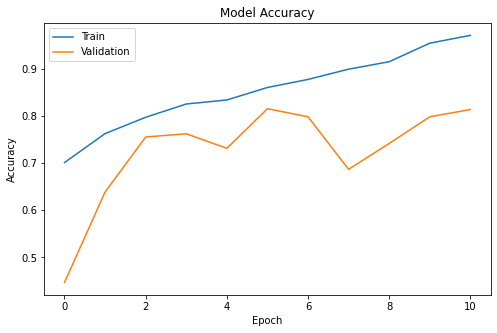

In [13]:
import matplotlib.pyplot as plt
# evaluate the ResNet-50 model after training the model
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

# 5.Model Prediction

In [14]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df1,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3784\2271427693.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)


2929/2929 [==============================] - 1348s 459ms/step


In [20]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

C:\Users\DELL\AppData\Local\Temp\ipykernel_3784\2753895509.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)


733/733 [==============================] - 324s 442ms/step


# 6.Model Evaluation

In [19]:
#print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df1['diagnosis'].astype('int'),train_preds))

Train Accuracy score : 0.896


In [18]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df1['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df1['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.937
Train Accuracy score : 0.896


In [24]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df2['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df2['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.839
Test Accuracy score : 0.797


In [25]:
#print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df2['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df2['diagnosis'].astype('int'),test_labels))

Test Accuracy score : 0.797


In [21]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

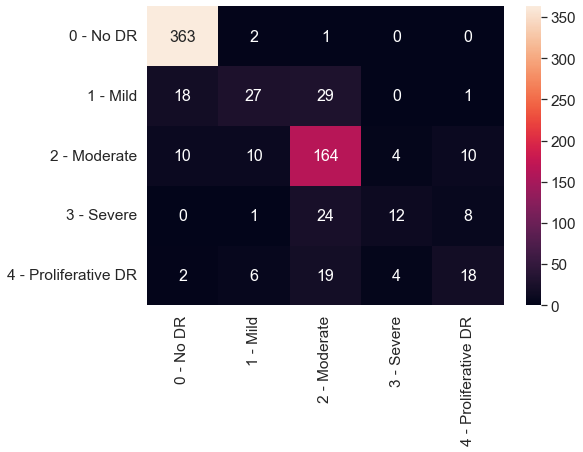

In [32]:
from sklearn.metrics import confusion_matrix

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df2['diagnosis'].astype(int)),test_labels,labels)

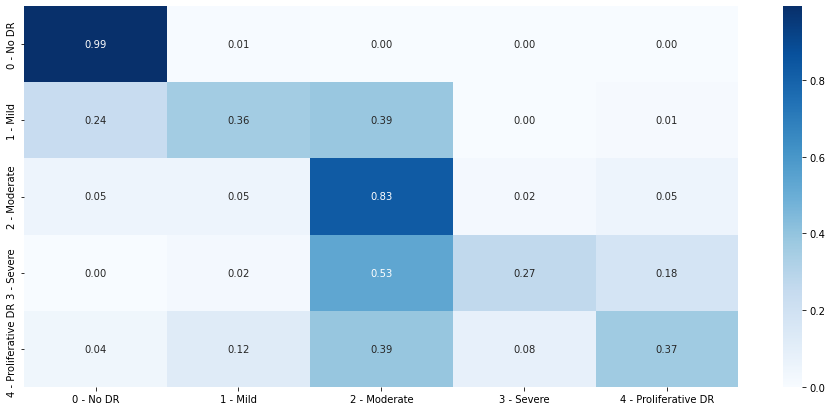

In [31]:
import seaborn as sns

cnf_matrix = confusion_matrix(df2['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [27]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+


# Model Saving

In [34]:
from keras.models import load_model

# Assuming that your model is named `model`
model.save('my_model.h5')

In [35]:
model_loaded= load_model('my_model.h5') # loads the model from the saved file

In [36]:
model_loaded # just checking the model loaded

In [37]:
model_loaded.summary() # just checking the loaded model weights

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 